In [1]:
# 定义保存数据的类
import numpy as np

#定义类
class IPAccessData(object):
    def __init__(self, X, y, coverage):
        self.X = X
        self.y = y
        self.coverage = coverage
#         self.ip_dict = ip_dict
#         self.ip_reserve_list = ip_reserve_list
#         self.data_scaler = data_scaler


In [2]:
time_window = 240
time_steps = 20
dimension = 32
n_class = 2

In [3]:
import pickle
# fp = open('iPAccessData_time_window_'+str(time_window)+'.pkl','rb',True)
fp = open('iPAccessData_count.pkl','rb',True)
iPAccessData = pickle.load(fp)
# X = iPAccessData.X
# labels = iPAccessData.y

In [4]:
iPAccessData.y.shape

(13385,)

In [5]:
#截取一部分数据（因为正常数据太多了）
X0 = iPAccessData.X[iPAccessData.y==0]
C0 = iPAccessData.coverage[iPAccessData.y==0]
# random_select = np.random.choice(X0.shape[0], 4000) #随即选择200个数据
# X0 = X0[random_select]
# C0 = C0[random_select]

X1 = iPAccessData.X[iPAccessData.y==1]
C1 = iPAccessData.coverage[iPAccessData.y==1]

X2 = iPAccessData.X[iPAccessData.y==2]
C2 = iPAccessData.coverage[iPAccessData.y==2]
# random_select = np.random.choice(X2.shape[0], 4000) #随即选择200个数据
# X2 = X2[random_select]
# C2 = C2[random_select]


X = np.concatenate((X0, X1, X2), axis=0) #与异常标签数据合并
labels = np.concatenate((np.zeros(X0.shape[0]), np.ones(X1.shape[0]), np.ones(X2.shape[0])) , axis=0) #与异常标签数据合并
coverages = np.concatenate((C0, C1, C2), axis=0)
print (X.shape)
print (labels)
print (coverages)

(13385, 20, 32)
[ 0.  0.  0. ...,  1.  1.  1.]
[ 0.37142857  0.37142857  0.53846154 ...,  0.21052632  0.23333333
  0.23333333]


In [6]:
import keras

y = keras.utils.to_categorical(labels, num_classes=n_class)

print(X.shape)
print(labels.shape)
print(y.shape)

Using TensorFlow backend.


(13385, 20, 32)
(13385,)
(13385, 2)


In [7]:
from sklearn.model_selection import train_test_split
X = X.reshape([-1,time_steps*dimension])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.50, random_state=888)

test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5, random_state=888)

train_X = train_X.reshape([-1,time_steps,dimension])
test_X = test_X.reshape([-1,time_steps,dimension])
val_X = val_X.reshape([-1,time_steps,dimension])
print (train_X.shape, test_X.shape, val_X.shape)

(6692, 20, 32) (3346, 20, 32) (3347, 20, 32)


In [8]:
# 定义神经网络
# 原始数据--向量LSTM（64）--全连接Dense（64）--全连接Dense（2）

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, dimension),name='lstm_layer'))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',name='dense1'))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_X, train_y, batch_size=64, epochs=50,validation_data=(val_X, val_y))
# score = model.evaluate(x_test, y_test, batch_size=16)

Train on 6692 samples, validate on 3347 samples
Epoch 1/50
6692/6692 [==============================] - 12s - loss: 0.5597 - acc: 0.7001 - val_loss: 0.4888 - val_acc: 0.7544
Epoch 2/50
6692/6692 [==============================] - 2s - loss: 0.4776 - acc: 0.7809 - val_loss: 0.4457 - val_acc: 0.7897
Epoch 3/50
6692/6692 [==============================] - 2s - loss: 0.4521 - acc: 0.7927 - val_loss: 0.4273 - val_acc: 0.8031
Epoch 4/50
6692/6692 [==============================] - 2s - loss: 0.4370 - acc: 0.8011 - val_loss: 0.4202 - val_acc: 0.8031
Epoch 5/50
6692/6692 [==============================] - 2s - loss: 0.4339 - acc: 0.8045 - val_loss: 0.4113 - val_acc: 0.8091
Epoch 6/50
6692/6692 [==============================] - 2s - loss: 0.4264 - acc: 0.8038 - val_loss: 0.4050 - val_acc: 0.8052
Epoch 7/50
6692/6692 [==============================] - 2s - loss: 0.4194 - acc: 0.8105 - val_loss: 0.4002 - val_acc: 0.8118
Epoch 8/50
6692/6692 [==============================] - 2s - loss: 0.4182 - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


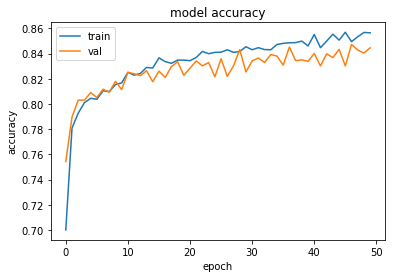

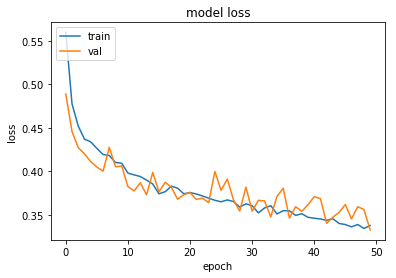

In [9]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
#每一个类别，进行识别率和F1-score验证
pred_y = model.predict(test_X, batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)

In [12]:
from sklearn.metrics import classification_report

print (classification_report(test_idx, pred_idx))
# print (test_generator.class_indices)

             precision    recall  f1-score   support

          0       0.78      0.84      0.81      1349
          1       0.88      0.84      0.86      1997

avg / total       0.84      0.84      0.84      3346



In [21]:
# from keras.models import Model
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer('dense1').output)

# intermediate_output = intermediate_layer_model.predict(test_X)

In [22]:
# from keras.models import load_model

model.save('single_layer_lstm.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
# model = load_model('my_model.h5')

In [23]:
false_negative = (pred_idx==0) & (test_idx==1) #被认为是正常，但是实际上是异常
false_positive = (pred_idx==1) & (test_idx==0) #被认为是异常，但是实际上正常

In [24]:
a = test_X[false_negative]
a[2]

array([[  2.14403607e-02,  -4.98553403e-02,   1.32720508e-02,
          2.01227404e-02,   5.88314608e-03,  -4.07213941e-02,
          4.78119515e-02,  -8.71802494e-03,   4.44088317e-02,
          4.95801084e-02,   2.23480351e-02,  -4.55139540e-02,
          4.19646241e-02,  -4.84270826e-02,  -1.22557655e-02,
          3.04076783e-02,  -2.49246601e-02,   3.15491296e-02,
          2.58730315e-02,  -4.19905186e-02,  -1.91657897e-02,
         -4.37935442e-03,  -1.41359568e-02,   3.74397971e-02,
          1.21073127e-02,   3.71897221e-03,   2.06530727e-02,
         -3.67375985e-02,  -4.68915366e-02,  -4.13324460e-02,
          5.86502627e-03,   1.06967613e-03],
       [  4.48885672e-02,   4.18888666e-02,   2.51195915e-02,
         -1.79908499e-02,   2.98619531e-02,  -3.22586522e-02,
          4.24681567e-02,  -4.57884073e-02,  -3.89108434e-02,
          3.44785489e-02,   1.33329630e-03,  -3.81248817e-02,
          1.09237805e-02,  -4.08381708e-02,  -5.29779121e-03,
         -2.03648694e-02,

In [25]:
#给定一组数据，返回这个数据在原始数据中的index，可以直接用iPAccessData.成员【index】来查看的
def find_data_position(samples):
    indexes = list()
    for x in samples:
        a = (np.abs(iPAccessData.X-x).sum(axis=2).sum(axis=1)<0.00001)
        indexes.append([np.where(a==1)[0],])
    return indexes

In [26]:
b = np.where(false_positive==1)#查一下那些是错误的
b

(array([   5,   21,   34,   83,  119,  173,  175,  180,  206,  210,  260,
         301,  317,  322,  327,  339,  365,  382,  383,  433,  441,  462,
         474,  480,  489,  499,  540,  544,  574,  609,  615,  620,  628,
         645,  655,  693,  701,  738,  751,  754,  758,  762,  764,  836,
         839,  843,  903,  915,  950,  959,  984,  994, 1038, 1063, 1073,
        1079, 1088, 1157, 1160, 1177, 1193, 1279, 1299, 1337, 1341, 1351,
        1353, 1355, 1377, 1414, 1433, 1462, 1499, 1579, 1603, 1615, 1627,
        1630, 1660, 1663, 1712, 1719, 1728, 1731, 1792, 1798, 1823, 1868,
        1871, 1879, 1913, 1920, 1923, 1936, 1941, 1959, 1975, 1992, 2026,
        2028, 2101, 2154, 2176, 2181, 2192, 2195, 2204, 2209, 2255, 2260,
        2281, 2334, 2345, 2352, 2373, 2428, 2456, 2493, 2513, 2522, 2524,
        2544, 2552, 2611, 2621, 2649, 2666, 2684, 2693, 2702, 2705, 2713,
        2718, 2725, 2741, 2749, 2751, 2769, 2887, 2894, 2920, 2924, 2940,
        2947, 2950, 2962, 2994, 3003, 

In [50]:
pred_y[1631]

array([ 0.16351546,  0.83648449], dtype=float32)

In [42]:
a = find_data_position(test_X[false_positive]) #注意如果是单个数据，一定要把这个数据在包装一层数组
a

[array([13224], dtype=int64),
 array([7798], dtype=int64),
 array([9714], dtype=int64),
 array([1990], dtype=int64),
 array([7846], dtype=int64),
 array([10069], dtype=int64),
 array([10277], dtype=int64),
 array([5610], dtype=int64),
 array([1282], dtype=int64),
 array([11420], dtype=int64),
 array([3550], dtype=int64),
 array([6625], dtype=int64),
 array([2158], dtype=int64),
 array([12349], dtype=int64),
 array([12092], dtype=int64),
 array([2881], dtype=int64),
 array([6480], dtype=int64),
 array([7853], dtype=int64),
 array([1363], dtype=int64),
 array([10772], dtype=int64),
 array([9091], dtype=int64),
 array([4265], dtype=int64),
 array([9949], dtype=int64),
 array([1277], dtype=int64),
 array([6856], dtype=int64),
 array([4583], dtype=int64),
 array([12769], dtype=int64),
 array([8447], dtype=int64),
 array([8368], dtype=int64),
 array([7930], dtype=int64),
 array([9654], dtype=int64),
 array([4540], dtype=int64),
 array([10452], dtype=int64),
 array([5975], dtype=int64),
 arra

In [67]:
#在总数据里面的idx，在test里面的idx，预测的概率
for i in range(len(a)):
    print (a[i][0], b[0][i], pred_y[b[0][i]])

13224 49 [ 0.36890817  0.63109183]
7798 90 [ 0.27062047  0.72937953]
9714 325 [ 0.22605312  0.77394688]
1990 341 [ 0.35882986  0.64117014]
7846 413 [ 0.1796633  0.8203367]
10069 428 [ 0.47748888  0.52251112]
10277 560 [ 0.38671881  0.61328125]
5610 570 [ 0.28498054  0.7150194 ]
1282 628 [ 0.05666972  0.94333029]
11420 668 [ 0.37360263  0.62639737]
3550 692 [ 0.29467994  0.70532   ]
6625 717 [ 0.42988044  0.57011962]
2158 773 [ 0.1825189   0.81748116]
12349 776 [ 0.38160571  0.61839426]
12092 797 [ 0.40513548  0.59486449]
2881 802 [ 0.46488982  0.53511018]
6480 804 [ 0.37275279  0.62724727]
7853 842 [ 0.15036769  0.84963238]
1363 879 [ 0.17627154  0.82372844]
10772 885 [ 0.16403788  0.83596212]
9091 920 [ 0.30655143  0.6934486 ]
4265 992 [ 0.35400149  0.64599854]
9949 1034 [ 0.4592596   0.54074037]
1277 1060 [ 0.43387842  0.56612158]
6856 1062 [ 0.39480564  0.60519433]
4583 1086 [ 0.04943732  0.95056266]
12769 1099 [ 0.20493373  0.79506624]
8447 1186 [ 0.26766196  0.73233801]
8368 1188 

In [41]:
iPAccessData.y[[3891,  7445, 11832]]

array([ 1.,  1.,  1.])

In [39]:
iPAccessData.X[5241] - iPAccessData.X[8152]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
  

In [50]:
#读取之前的url_list数据，配合假阴性假阳性判断
class IPAccessInfo(object):
    def __init__(self, all_url_list, all_url_dict_list):
        self.all_url_list = all_url_list
        self.all_url_dict_list = all_url_dict_list
        
import pickle
fp = open('url_info.pkl','rb',True)
iPAccessInfo = pickle.load(fp)

In [94]:
false_negative_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_negative) if v==True]
false_negative_urls  #被认为是正常，但是实际上是异常的，看看对不对吧

NameError: name 'iPAccessInfo' is not defined

In [52]:
false_positive_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_positive) if v==True]
false_positive_urls  #被认为是异常，但是实际上是正常的，看看对不对吧

[['POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'GET common/.../patientList.do',
  'GET /.../patientinfo.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'POST /.../reserve.do'],
 ['GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do'],
 ['GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'GET common/.../login.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDept.do',
  'GET common/.../chooseExpert.do',
  'GET common/.../deptList.do',
  'POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do'],
 ['GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDe

In [13]:
#用behavior尝试进行分类，然后投票决定。看看双层的结构好，还是2-steps的结构好
import pickle
# fp = open('iPAccessData_time_window_'+str(time_window)+'.pkl','rb',True)
fp = open('iPAccessData_behavior.pkl','rb',True)
iPAccessData_behavior = pickle.load(fp)
# X = iPAccessData.X
# labels = iPAccessData.y

In [34]:
iPAccessData_behavior.X.shape

(6982, 10, 20, 32)

In [36]:
test_behavior = iPAccessData_behavior.X.reshape([iPAccessData_behavior.X.shape[0]*iPAccessData_behavior.X.shape[1],iPAccessData_behavior.X.shape[2],iPAccessData_behavior.X.shape[3]])
test_behavior.shape

(69820, 20, 32)

In [57]:
#统一预测
test_behavior_predict_ori = model.predict(test_behavior, batch_size=32, verbose=0)

In [112]:
#整理预测数据，每10个一组
test_behavior_predict = test_behavior_predict_ori.reshape([-1,20])
test_behavior_predict.shape

(6982, 20)

In [117]:
#把数据保存起来，用于train_two_layer_structure_classifier。ipynb
layer1_out = dict()
layer1_out['data'] = test_behavior_predict
layer1_out['label'] = iPAccessData_behavior.y

print (layer1_out['data'].shape)
print (layer1_out['label'].shape)

# 保存文件为pkl
import pickle

fp = open('iPAccessData_layer1_out.pkl','wb',True)
pickle.dump(layer1_out, fp)

(6982, 20)
(6982,)


In [118]:
pred_hebavior = np.zeros([iPAccessData_behavior.y.shape[0]])
test_behavior 

for i in range(iPAccessData_behavior.y.shape[0]):
    pred_hebavior[i] = np.argmax(test_behavior_predict[i].sum(axis=0))
#     print (pred_hebavior[i],iPAccessData_behavior.y[i])

In [119]:
test_behavior_label = iPAccessData_behavior.y
test_behavior_label[test_behavior_label==2] = 0

from sklearn.metrics import classification_report

print (classification_report(test_behavior_label, pred_hebavior))
# print (test_generator.class_indices)

             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97      6590
        1.0       0.00      0.00      0.00       392

avg / total       0.89      0.94      0.92      6982



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
test_behavior_predict[2]

array([  8.72923195e-01,   8.14644864e-06,   8.72923195e-01,
         8.72923195e-01,   9.59695399e-01,   8.72923195e-01,
         8.72923195e-01,   8.72923195e-01,   8.72923195e-01,
         9.45646942e-01,   1.27076745e-01,   9.99991894e-01,
         1.27076745e-01,   1.27076745e-01,   4.03046720e-02,
         1.27076745e-01,   1.27076745e-01,   1.27076745e-01,
         1.27076745e-01,   5.43530621e-02], dtype=float32)

In [93]:
iPAccessData_behavior.y[2]

1.0

In [94]:
model.predict(iPAccessData_behavior.X[2], batch_size=32, verbose=0)

array([[  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00],
       [  3.20101243e-08,   1.00000000e+00]], dtype=float32)

In [116]:
test_behavior_predict[0]

array([ 0.1424136 ,  0.85758638,  0.65312135,  0.34687862,  0.8729232 ,
        0.12707675,  0.8729232 ,  0.12707675,  0.8729232 ,  0.12707675,
        0.8729232 ,  0.12707675,  0.8729232 ,  0.12707675,  0.8729232 ,
        0.12707675,  0.8729232 ,  0.12707675,  0.8729232 ,  0.12707675], dtype=float32)

In [111]:
b = a.reshape([-1,20]).reshape([-1,20],order='F')
b.shape
b

array([[  1.42413601e-01,   8.57586384e-01,   6.53121352e-01,
          3.46878618e-01,   8.72923195e-01,   1.27076745e-01,
          8.72923195e-01,   1.27076745e-01,   8.72923195e-01,
          1.27076745e-01,   8.72923195e-01,   1.27076745e-01,
          8.72923195e-01,   1.27076745e-01,   8.72923195e-01,
          1.27076745e-01,   8.72923195e-01,   1.27076745e-01,
          8.72923195e-01,   1.27076745e-01],
       [  6.97831064e-02,   9.30216968e-01,   7.79171335e-03,
          9.92208302e-01,   3.62619013e-01,   6.37380958e-01,
          5.52474707e-02,   9.44752514e-01,   9.23912525e-02,
          9.07608688e-01,   1.23145312e-01,   8.76854718e-01,
          7.14507222e-01,   2.85492778e-01,   8.72923195e-01,
          1.27076745e-01,   8.72923195e-01,   1.27076745e-01,
          8.72923195e-01,   1.27076745e-01],
       [  3.20101243e-08,   1.00000000e+00,   3.20101243e-08,
          1.00000000e+00,   3.20101243e-08,   1.00000000e+00,
          3.20101243e-08,   1.00000000e+00